In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import numpy as np
from scipy.spatial import distance
import math
import statistics

In [107]:
#filter specific file names
luminance = 'Light_Luminance_3.500_secs_001_reduced_matched.csv'
#luminance = 'RZ_Cep_Light_Luminance_10_secs_001_reduced_matched.csv'
red = 'star_Light_Red_30_secs_001_reduced_matched.csv'
green = 'star_Light_Green_30_secs_001_reduced_matched.csv'
blue = 'star_Light_Blue_30_secs_001_reduced_matched.csv'

#set current filter
ref_csv_name = luminance
current_filter = 'Luminance'

#define file read path and the file list, excluding the first file
#read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_02_23/RZ_Cep/CSVs/Matched Stars/{current_filter}')
read_path = Path(f'./RZ Cep/All_RZ_Cep/2023_11_10/RZ_Cep/CSVs/Matched Stars/{current_filter}')
file_list = [f for f in os.listdir(read_path)if f.endswith('.csv') and f != ref_csv_name]

final_csv_path = Path('./RZ Cep/All_RZ_Cep/Light Curve CSVs/')
final_csv_name = '2023_11_10_normalised_curve.csv'

In [108]:
#column names
# mag_name = 'Source_Mag'
# mag_error_name = 'Source_Mag_Error'
# corr_mag_name = 'Corrected_Mag'
# date_time_name = 'Date Observation'
# exp_time_name = 'Exposure time /s '
# star_id_name = 'star_id'
# x_pos_name = 'xcenter'
# y_pos_name = 'ycenter'

mag_name = 'instrumental_mag'
mag_error_name = 'mag_error'
corr_mag_name = 'corrected_mag'
date_time_name = 'date_time'
exp_time_name = 'exp_time'
star_id_name = 'star_id'
x_pos_name = 'x_center'
y_pos_name = 'y_center'

In [124]:
#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
star_counter = {}


#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row[star_id_name]
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row[mag_name] != np.nan and not math.isnan(row[mag_name]):
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row[mag_name]),
                    'corr_mag': float(row[corr_mag_name]),
                    'mag_error': float(row[mag_error_name]),
                    'date_time': str(row[date_time_name]),
                    'exp_time': float(row[exp_time_name])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row[x_pos_name], row[y_pos_name])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df[star_id_name].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                # Count times star shows up to prune later
                if star_name in star_counter:
                    star_counter[star_name] += 1
                else:
                    star_counter[star_name] = 1
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df[star_id_name] == star_name][mag_name])
                    if isinstance(mag, tuple):
                        mag = mag[0]
                    err = float(df.loc[df[star_id_name] == star_name][mag_error_name])
                    #print((df.loc[df['star_id'] == star_name]['corrected_mag']))
                    corr = float(str(df.loc[df[star_id_name] == star_name][corr_mag_name].iloc[0]))
                    if isinstance(corr, tuple):
                        corr = corr[0]
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df[star_id_name] == star_name][date_time_name])[0])
                    img_exptime = float(df.loc[df[star_id_name] == star_name][exp_time_name])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'corr_mag': corr,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        star_counter[star_name] -= 1
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df[star_id_name] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row[mag_name] != np.nan and not math.isnan(row[mag_name]):
                            if distance.euclidean(prev_pos, (row[x_pos_name], row[y_pos_name])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row[x_pos_name], row[y_pos_name]))
                                #save star properties to dictionary
#                                 print(float(row[mag_error_name]))
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row[mag_name]),
                                        'corr_mag': float(row[corr_mag_name]),
                                        'mag_error': float(row[mag_error_name]),
                                        'date_time': str(row[date_time_name]),
                                        'exp_time': float(row[exp_time_name])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row[x_pos_name], row[y_pos_name])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
        
#         #iterate over star names saved in list of stars to be deleted
#         for star_name in to_delete:
#         #delete saved position values for misidentification purposes
#             del valid_stars[star_name]
#             #delete all previous iterations of the star saved in the loop
#             for idx, previous_iters in enumerate(star_properties):
#                 if star_name in previous_iters:
#                     del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
#         to_delete = []
                        
max_star_count = max(star_counter.values())
for starname, count in star_counter.items():
    if count < (0.98 * max_star_count):
        for idx, previous_iters in enumerate(star_properties):
            if starname in previous_iters:
                del star_properties[idx][starname]
        
        
                
#print(valid_stars)
# print(star_properties)

#print dictionary properties for RZ Cep
# for star_num in star_properties:
#     print(star_num['V* RZ Cep'])

#print all star names saved in star_properties dictionary
print(star_properties)

# for star_name in star_properties[0]:
#     print(star_name)

[{'2MASS J22420892+6508103': {'img_number': 1, 'instrumental_mag': -14.58786641169005, 'corr_mag': -13.22769630081436, 'mag_error': -0.0013126563313348, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-149-1': {'img_number': 1, 'instrumental_mag': -13.131197042419949, 'corr_mag': -11.77102693154426, 'mag_error': -0.0025673490102245, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-876-1': {'img_number': 1, 'instrumental_mag': -14.228838580350018, 'corr_mag': -12.86866846947433, 'mag_error': -0.0015486618639207, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'TYC 4273-673-1': {'img_number': 1, 'instrumental_mag': -12.686243993300026, 'corr_mag': -11.326073882424335, 'mag_error': -0.0031511967603228, 'date_time': '2023-11-10T20:43:47.235', 'exp_time': 3.5}, 'Gaia DR3 2212402667093547008': {'img_number': 1, 'instrumental_mag': -12.524024713123527, 'corr_mag': -11.16385460224784, 'mag_error': -0.0033956223023102, 'date_time': '2023-11-10T20:

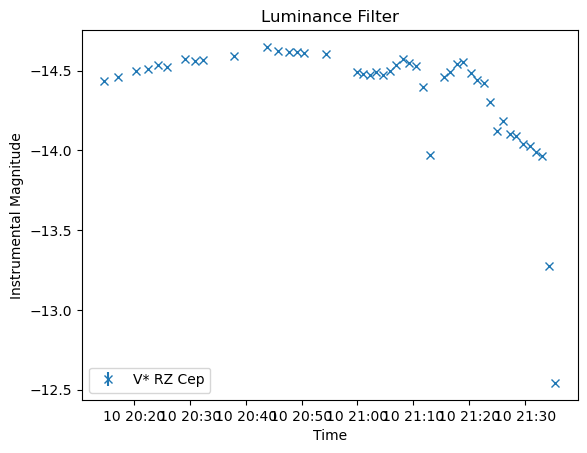

In [125]:
def get_plotting_dict(dataset):
    res = {}
    for image in dataset:
        for star_name, props in image.items():
            if star_name not in res:
                res[star_name] = {"corr_mag": [props["corr_mag"]], "time": [props["date_time"]], 
                                  'error': [props['mag_error']]}
            else:
                res[star_name]["time"].append(props["date_time"])
                res[star_name]["corr_mag"].append(props["corr_mag"])
                res[star_name]['error'].append(props['mag_error'])
    
    return res

star_plotting_dict = get_plotting_dict(star_properties)

star_to_plot = 'V* RZ Cep'
        
x = pd.to_datetime(star_plotting_dict[star_to_plot]["time"])
y = star_plotting_dict[star_to_plot]["corr_mag"]
err = np.abs(star_plotting_dict[star_to_plot]['error'])
plt.errorbar(x, y, yerr=err, marker='x', ls='None', label=star_to_plot)

plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

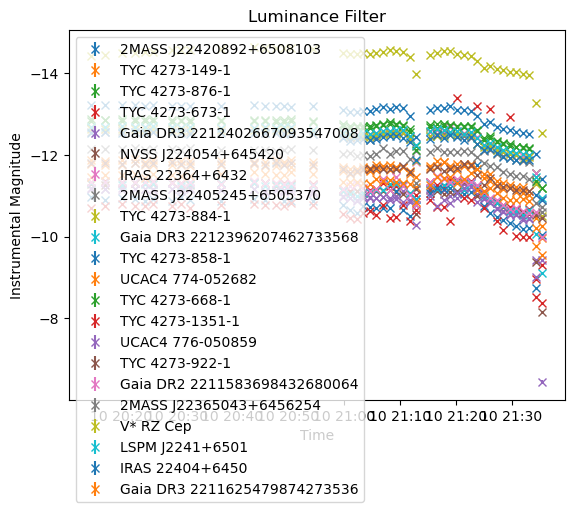

In [126]:
for star_name, magtimes in star_plotting_dict.items():
    x = pd.to_datetime(magtimes["time"])
    y = magtimes["corr_mag"]
    err = np.abs(magtimes['error'])
    plt.errorbar(x, y, yerr=err, marker='x', ls='None', label=star_name)

plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [127]:
def convert_df_to_mag_dict(df: pd.DataFrame, corr_mag_name_df) -> dict:
    """
    Converts a star dataframe (read in via pd.read_csv) to a dictionary of star names to magnitudes
    """
    ref_dict = {}
    for idx, row in df.iterrows():
        star_name = row[star_id_name]
        #checks for valid magnitudes (i.e. not from negative fluxes)
        if row[corr_mag_name_df] != np.nan and not math.isnan(row[corr_mag_name_df]) and star_name not in ref_dict:
            #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
            #the star name and its associated image number, magnitude, date/time and exposure time
            ref_dict[star_name] = float(row[corr_mag_name_df])
            #print(row[corr_mag_name_df], star_name)
    return ref_dict

def find_removal_candidates(dataset, threshold):
    point_changes = {}
    prev_point = {}
    for image in dataset:
        for star_name, props in image.items():
            if star_name in prev_point:
                if isinstance(props['corr_mag'], tuple):
                    res = abs(prev_point[star_name] - props["corr_mag"][0])
                else:
                    res = abs(prev_point[star_name] - props["corr_mag"])
                    
                if star_name in point_changes:
                    point_changes[star_name].append(res)
                else:
                    point_changes[star_name] = [res]
            
            if isinstance(props['corr_mag'], tuple):
                prev_point[star_name] = props["corr_mag"][0]
            else:
                prev_point[star_name] = props["corr_mag"]
    
#     print(point_changes)
    change_means = {}
    for key, val in point_changes.items():
        change_means[key] = np.mean(val)
    
    print(change_means)
        
    return [key for key, val in change_means.items() if val > threshold]

def remove_stars(names_of_stars_to_remove, dataset):
    for image in dataset:
        for name in names_of_stars_to_remove:
            if name in image:
                del image[name]

def get_correction_factor_img_by_img(
    dict_list: list[dict[dict]], 
    reference_df: pd.DataFrame, 
    corrected_magnitude_name) -> list[list[float, float]]:
    
    final_correction_factors: list[list[float, float]] = []
    temp_correction_factors: list = []
    reference_for_stars = convert_df_to_mag_dict(reference_df, 'corrected_mag')

    #print(reference_for_stars)
    
    for image in dict_list:
        star_in_both = (reference_for_stars.keys() & image.keys()) - {'V* RZ Cep'}
        star_in_im_not_ref = (image.keys() - reference_for_stars.keys()) - {'V* RZ Cep'}

        temp_correction_factors = []
        for star_name in star_in_both:
            if isinstance(image[star_name][corrected_magnitude_name], tuple):
                temp_correction_factors.append(reference_for_stars[star_name] -
                                              image[star_name][corrected_magnitude_name][0])
            else:
                temp_correction_factors.append(reference_for_stars[star_name] -
                                              image[star_name][corrected_magnitude_name])

        for star_name in star_in_im_not_ref:
            if isinstance(image[star_name][corrected_magnitude_name], tuple):
                reference_for_stars[star_name] = image[star_name][corrected_magnitude_name][0]
            else:
                reference_for_stars[star_name] = image[star_name][corrected_magnitude_name]
            
            temp_correction_factors.append(np.mean(temp_correction_factors))

        final_correction_factors.append([np.mean(temp_correction_factors), 
                                         np.std(temp_correction_factors)/np.sqrt(len(temp_correction_factors))])
        
    return final_correction_factors

In [128]:
ref_df = pd.read_csv(f'./RZ Cep/All_RZ_Cep/2023_01_23/RZ_Cep/CSVs/Matched Stars/Luminance/star_Light_Luminance_10_secs_001_reduced_matched.csv')
ref_df['corrected_mag']

# print(correction_factors)

0     -14.131119
1     -13.071510
2     -13.346190
3     -12.721426
4     -12.467651
         ...    
145    -8.596713
146    -8.691852
147    -8.815328
148    -9.267526
149    -9.013960
Name: corrected_mag, Length: 150, dtype: float64

In [133]:
removal_stars_maybe = find_removal_candidates(star_properties, 0.1)
print(removal_stars_maybe)
remove_stars(removal_stars_maybe, star_properties)

{'2MASS J22420892+6508103': 0.08953037584189233, 'TYC 4273-149-1': 0.08674683493916548, 'TYC 4273-876-1': 0.07542186755216601, 'TYC 4273-673-1': 0.10615643936036519, 'Gaia DR3 2212402667093547008': 0.09692363132715387, 'NVSS J224054+645420': 0.1268925979695309, 'IRAS 22364+6432': 0.09035902236562955, '2MASS J22405245+6505370': 0.0764147668232194, 'TYC 4273-884-1': 0.09139863344916743, 'Gaia DR3 2212396207462733568': 0.11278903489777427, 'TYC 4273-858-1': 0.21980303791231104, 'UCAC4 774-052682': 0.08251150987474093, 'TYC 4273-668-1': 0.08219187419141198, 'TYC 4273-1351-1': 0.5953255211830191, 'UCAC4 776-050859': 0.1788962417033324, 'TYC 4273-922-1': 0.08554293972880203, 'Gaia DR2 2211583698432680064': 0.10873555127942665, '2MASS J22365043+6456254': 0.09519953747061069, 'V* RZ Cep': 0.08856786777280547, 'LSPM J2241+6501': 0.07691083043692863, 'IRAS 22404+6450': 0.08154451098073111, 'Gaia DR3 2211625479874273536': 0.11115575952742142}
['TYC 4273-673-1', 'NVSS J224054+645420', 'Gaia DR3 22

In [134]:
correction_factors = get_correction_factor_img_by_img(star_properties, ref_df, 'corr_mag')
# print(correction_factors)

In [135]:
#iterate over star_properties to correct all the magnitudes
for image_number, dictionary in enumerate(star_properties):
    #iterate over each star name
    for star_name in dictionary.keys():
        #apply correction factor to each magnitude for each star
        if isinstance(star_properties[image_number][star_name]['corr_mag'], tuple) == True:
            intermediate = list(star_properties[image_number][star_name]['corr_mag'])
            for i in range(len(intermediate)):
                intermediate[i] = correction_factors[image_number][0] + intermediate[0]
            star_properties[image_number][star_name]['corr_mag'] = intermediate[0]
#             star_properties[image_number][star_name]['corr_mag'][0] *= condensed_correction_factors[image_number][0]
        else:
            star_properties[image_number][star_name]['corr_mag'] = correction_factors[image_number][0] + star_properties[image_number][star_name]['corr_mag']
        
        star_properties[image_number][star_name]['mag_error'] += correction_factors[image_number][1]

# print(star_properties)

#no need for a second iteration, as correction factors all come out to approx 1 with std of 2-3 mags smaller

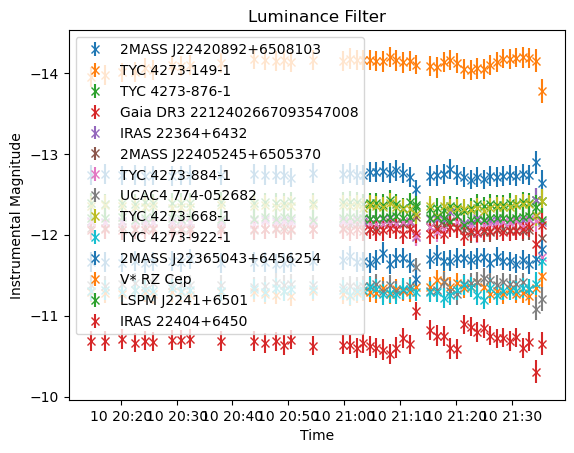

In [136]:
star_plotting_dict = get_plotting_dict(star_properties)

for star_name, magtimes in star_plotting_dict.items():
    x = pd.to_datetime(magtimes["time"])
    y = magtimes["corr_mag"]
    err = np.abs(magtimes['error'])
    plt.errorbar(x, y, yerr=err, marker='x', ls='None', label=star_name)

plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

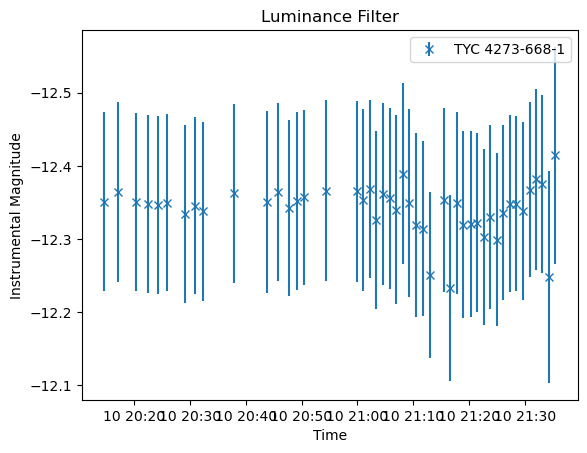

In [143]:
star_to_plot = 'TYC 4273-668-1'
        
x = pd.to_datetime(star_plotting_dict[star_to_plot]["time"])
y = star_plotting_dict[star_to_plot]["corr_mag"]
err = np.abs(star_plotting_dict[star_to_plot]['error'])
plt.errorbar(x, y, yerr=err, marker='x', ls='None', label=star_to_plot)

plt.title('Luminance Filter')
plt.xlabel('Time')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [144]:
#use ap stats error or sqrt counts

df_curve = pd.DataFrame(data=(y, err, x))
df_curve = df_curve.T
df_curve.columns = ['corrected_magnitude', 'magnitude_error', 'date_time']
df_curve.to_csv(final_csv_path / '2023_Nov_Brightest_3.csv')

In [71]:
df_curve

,corrected_magnitude,magnitude_error,date_time
0,-14.112348,0.026166,2023-01-23 20:57:18.475
1,-14.096607,0.028566,2023-01-23 20:59:31.651
2,-14.10756,0.036318,2023-01-23 21:01:44.732
3,-14.103147,0.022206,2023-01-23 21:03:57.173
4,-14.092619,0.032597,2023-01-23 21:06:08.129
...,...,...,...
107,-14.100649,0.034908,2023-01-23 20:19:16.880
108,-14.085522,0.025663,2023-01-23 20:22:18.040
109,-14.087127,0.024659,2023-01-23 20:25:19.088
110,-14.089262,0.025327,2023-01-23 20:28:22.084


In [7]:
'''
OLD CORRECTION FACTORS CODE



#define a correction factor function to apply to each star individually
def get_correction_factors(magnitudes: list[float]) -> list[float]:
    #set reference point as first image data set
    ref_mag = magnitudes[0]
    #set the first correction factor associated with the first image data set to 1
    corr_factors = [1]
    #iterate over all image data sets, excluding the first one
    for mag_current_image in magnitudes[1:]:
        #append the corrected factors array with a correction factor for each image
        corr_factors.append(ref_mag / mag_current_image)
    #return the correction factors for this star
    return corr_factors


#save list of star names without star of interest
names_without_cep = star_properties[0].keys() - {'V* RZ Cep'}
#set up a new empty dictionary conatining all the star names without rz cep
star_datapoints = {key: [] for key in names_without_cep}

#for each image in the star_properties list of dicts of dicts
for image in star_properties:
    #iterate over the star names without rz cep
    for star_name in names_without_cep:
        if star_name in image:
            if isinstance(image[star_name]['corr_mag'], tuple):
                star_datapoints[star_name].append(image[star_name]['corr_mag'][0])
            else:
                star_datapoints[star_name].append(image[star_name]['corr_mag'])
        else:
            star_datapoints[star_name].append(star_datapoints[star_name]['corr_mag'][0])


#create a list of lists containing all image by image correction factors for each individual star
imgbyimg_factors = [get_correction_factors(val) for key, val in star_datapoints.items()]

# print(imgbyimg_factors[0])
#set up list of lists containing the mean and std of each image's correction factors
condensed_correction_factors = [
    [
        np.mean([row[colnum] for row in imgbyimg_factors]),
        np.std([row[colnum] for row in imgbyimg_factors])
    ] for colnum, _ in enumerate(imgbyimg_factors[0])
]
# condensed_correction_factors = []
# for row in imgbying_factors:
    
    
# print(condensed_correction_factors)
#print(len(condensed_correction_factors))
#first sq bracket changes image, second square bracket changes between mean and standard deviation
#print(condensed_correction_factors[0][1])
'''
pass

In [4]:
'''
OLD DICTIONARY MAKING CODE



#set up a dictionary of valid star names 
valid_stars = None

#set up a list which will contain dictionaries of stars and their associated magnitudes, date/times and exposure times
star_properties = []
to_delete = []

#enumerate adds an index to each file in the list
for i, fname in enumerate(file_list):
    #read in the dataframe
    df = pd.read_csv(read_path / fname)
    #add an empty dictionary to star_properties
    star_properties.append({})
    
    #if the dictionary valid_stars has not been created, create it
    #assumes all stars in the first dataframe (image 2) appear only once, which they do
    if valid_stars is None:
        valid_stars = {}
        #iterate through row and associated index in the dataframe, iterrows allows for this
        for idx, row in df.iterrows():
            #extract star name from dataframe
            star_name = row['star_id']
            #checks for valid magnitudes (i.e. not from negative fluxes)
            if row['instrumental_mag'] != np.nan:
                #set up new row in the star_properties dictionary (index i to be associated with dataframe/image i) to save
                #the star name and its associated image number, magnitude, date/time and exposure time
                star_properties[i][star_name] = {
                    'img_number': i + 1,
                    'instrumental_mag': float(row['instrumental_mag']),
                    'corr_mag': float(row['corrected_mag']),
                    'mag_error': float(row['mag_error']),
                    'date_time': str(row['date_time']),
                    'exp_time': float(row['exp_time'])
                }
                #add new row to valid_stars dictionary to save the position values
                valid_stars[star_name] = (row['x_center'], row['y_center'])
                
    #if valid_stars has already been created, so for any other dataframe that is not the first one:            
    else:
        #counts how many times each star's name has occured in the dataframe
        vcounts = df['star_id'].value_counts()
        #iterates through star names and positions saved in the valid_stars dictionary
        for star_name, (xpos, ypos) in valid_stars.items():
            #run if the star is in the dataframe, otherwise the star will not be considered this loop iteration
            if star_name in vcounts:
                #if the star appears only once in the dataframe, run this
                if vcounts[star_name] == 1:   
                    #all properties must be type converted first here, as they output as a pd.string when using df.loc
                    mag = float(df.loc[df['star_id'] == star_name]['instrumental_mag'])
                    err = float(df.loc[df['star_id'] == star_name]['mag_error'])
                    #print((df.loc[df['star_id'] == star_name]['corrected_mag']))
                    corr = float(str(df.loc[df['star_id'] == star_name]['corrected_mag'].iloc[0])),
                    #time needs to be output as a string, using just str() didn't eliminate the associated index
                    #first, it is converted to a list and the zeroth index value (the only value) converted into a string, 
                    #which gets around this issue
                    time = str(list(df.loc[df['star_id'] == star_name]['date_time'])[0])
                    img_exptime = float(df.loc[df['star_id'] == star_name]['exp_time'])
                    if mag != np.nan and not math.isnan(mag):
                        #properties are saved to the dictionary, added to the section corresponding to that star
                        star_properties[i][star_name] = {
                                'img_number': i + 1,
                                'instrumental_mag': mag,
                                'corr_mag': corr,
                                'mag_error': err,
                                'date_time': time,
                                'exp_time': img_exptime
                            }
                    else:
                        to_delete.append(star_name)
                #if the star appears more or less than once, run this
                else:
                    #save the previous position to a variable
                    prev_pos = (xpos, ypos)
                    #set up an arbitrary minimum distance
                    min_dist = np.inf
                    #iterate through all the duplicate instances of the star in the dataframe
                    for idx, row in df[df['star_id'] == star_name].iterrows():
                        #test if the distance between the position of this star instance is less than either the arbitrary
                        #distance or the other points associated with other instances of the star in the dataframe.
                        #if the new distance is less than the min distance for other star instances, the current instance
                        #is more likely to be the correct star and not a mislabeled one
                        if row["instrumental_mag"] != np.nan and not math.isnan(row["instrumental_mag"]):
                            if distance.euclidean(prev_pos, (row['x_center'], row['y_center'])) < min_dist:
                                #update the new minimum point distance
                                min_dist = distance.euclidean(prev_pos, (row['x_center'], row['y_center']))
                                #save star properties to dictionary
                                star_properties[i][star_name] = {
                                        'img_number': i + 1,
                                        'instrumental_mag': float(row['instrumental_mag']),
                                        'corr_mag': float(str(row['corrected_mag'])),
                                        'mag_error': float(row['mag_error']),
                                        'date_time': str(row['date_time']),
                                        'exp_time': float(row['exp_time'])
                                    }
                                #overwrite star position in valid_stars                          
                                valid_stars[star_name] = (row['x_center'], row['y_center'])
                        #if the star is not in the image, add it a list of star names to be removed (first condition)
                        else:
                            to_delete.append(star_name)
            #if the star is not in the image, add it to a list of stars to be deleted (second condition)
            else:
                to_delete.append(star_name)
        
        #iterate over star names saved in list of stars to be deleted
        for star_name in to_delete:
        #delete saved position values for misidentification purposes
            del valid_stars[star_name]
            #delete all previous iterations of the star saved in the loop
            for idx, previous_iters in enumerate(star_properties):
                if star_name in previous_iters:
                    del star_properties[idx][star_name]
        
        #reset the list of stars to delete, so stars are not removed twice
        to_delete = []
                        
                        
                
#print(valid_stars)
# print(star_properties)

#print dictionary properties for RZ Cep
# for star_num in star_properties:
#     print(star_num['V* RZ Cep'])
    
#print all star names saved in star_properties dictionary
for star_name in star_properties[0]:
    print(star_name)
'''
pass